# Calculate network routes between randomized origins and destinations

IGNORING FREEWAYS + USING IGRAPH + RANDOM ODs

In [1]:
import igraph as ig
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.stats import ttest_ind

np.random.seed(0)
simulate_all_trips = True

## Load network and ODs

In [2]:
%%time
# load the networks
G_dir = ox.load_graphml('data/network/sf-directed-no-fwy.graphml', folder='.')
G_undir = ox.load_graphml('data/network/sf-undirected-no-fwy.graphml', folder='.')

Wall time: 3.54 s


In [3]:
print(nx.is_strongly_connected(G_dir))
print(nx.is_strongly_connected(G_undir))

True
True


In [4]:
# generate random ODs from the nodes common to both graphs
# (so we're simulating the same set of trips on each graph)
nodes_dir = ox.graph_to_gdfs(G_dir, edges=False, node_geometry=False, fill_edge_geometry=False)
nodes_undir = ox.graph_to_gdfs(G_undir, edges=False, node_geometry=False, fill_edge_geometry=False)
common_nodes = pd.Series(list(set(nodes_dir.index.tolist()) & set(nodes_undir.index.tolist())))

od_dir = pd.DataFrame()
od_dir['orig'] = common_nodes.sample(frac=1).values
od_dir['dest'] = common_nodes.sample(frac=1).values
od_undir = od_dir

In [5]:
# confirm the origins and destinations match between the two datasets
assert (od_dir['orig']==od_undir['orig']).sum() == len(od_dir) == len(od_undir)
assert (od_dir['dest']==od_undir['dest']).sum() == len(od_dir) == len(od_undir)
print(len(od_dir))

9263


## How many trips to simulate

In [6]:
# there are 1,133,333 daily trips that being/end in SF
if simulate_all_trips:
    total_daily_trips = 1133333
    multiplier = total_daily_trips / len(od_dir)
    multiplier = math.ceil(multiplier)
else:
    multiplier = 1
multiplier

123

In [7]:
od_dir = pd.concat([od_dir]*multiplier, ignore_index=True)
len(od_dir)

1139349

In [8]:
od_undir = pd.concat([od_undir]*multiplier, ignore_index=True)
len(od_dir)

1139349

## Convert networkx graphs to igraph

In [9]:
weight = 'length'

G_dir = nx.relabel.convert_node_labels_to_integers(G_dir)
G_dir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_dir.nodes().items()}

G_undir = nx.relabel.convert_node_labels_to_integers(G_undir)
G_undir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_undir.nodes().items()}

In [10]:
%%time
# convert directed networkx graph to igraph
G_dir_ig = ig.Graph(directed=True)
G_dir_ig.add_vertices(list(G_dir.nodes()))
G_dir_ig.add_edges(list(G_dir.edges()))
G_dir_ig.vs['osmid'] = list(nx.get_node_attributes(G_dir, 'osmid').values())
G_dir_ig.es[weight] = list(nx.get_edge_attributes(G_dir, weight).values())

assert len(G_dir.nodes()) == G_dir_ig.vcount()
assert len(G_dir.edges()) == G_dir_ig.ecount()

Wall time: 58.1 ms


In [11]:
%%time
# convert undirected networkx graph to igraph
G_undir_ig = ig.Graph(directed=False)
G_undir_ig.add_vertices(list(G_undir.nodes()))
G_undir_ig.add_edges(list(G_undir.edges()))
G_undir_ig.vs['osmid'] = list(nx.get_node_attributes(G_undir, 'osmid').values())
G_undir_ig.es[weight] = list(nx.get_edge_attributes(G_undir, weight).values())

assert len(G_undir.nodes()) == G_undir_ig.vcount()
assert len(G_undir.edges()) == G_undir_ig.ecount()

Wall time: 74.5 ms


## Calculate routes between origins and destinations

#### First, look at topological graph distance (number of edges/blocks traversed)

In [12]:
# calculate shortest path topological distance (edges) between rows' origin and destination nodes
def network_distance(row, G_ig, nodeid_to_osmid, weight=None):
    try:
        source = nodeid_to_osmid[row['orig']]
        target = nodeid_to_osmid[row['dest']]
        return G_ig.shortest_paths(source=source, target=target, weights=weight)[0][0]
    except:
        return np.nan

In [13]:
%%time
# for the real-world directed graph
od_dir['network_distance_e'] = od_dir.apply(network_distance, axis=1, G_ig=G_dir_ig, nodeid_to_osmid=G_dir_nodeid_to_osmid)

Wall time: 21min 5s


In [14]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_e'] = od_undir.apply(network_distance, axis=1, G_ig=G_undir_ig, nodeid_to_osmid=G_undir_nodeid_to_osmid)

Wall time: 23min 51s


In [15]:
blocks_dir = od_dir['network_distance_e'].replace([np.inf, -np.inf], np.nan).dropna()
blocks_dir.describe()

count    1.139349e+06
mean     4.983310e+01
std      2.184978e+01
min      1.000000e+00
25%      3.300000e+01
50%      4.900000e+01
75%      6.500000e+01
max      1.200000e+02
Name: network_distance_e, dtype: float64

In [16]:
blocks_undir = od_undir['network_distance_e'].replace([np.inf, -np.inf], np.nan).dropna()
blocks_undir.describe()

count    1.139349e+06
mean     4.726104e+01
std      2.070935e+01
min      1.000000e+00
25%      3.100000e+01
50%      4.600000e+01
75%      6.200000e+01
max      1.130000e+02
Name: network_distance_e, dtype: float64

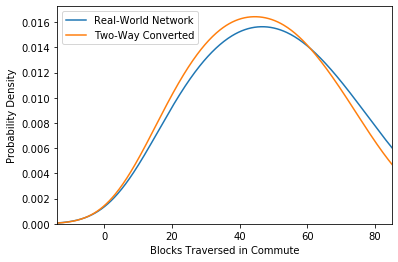

In [17]:
bw = 0.4
lw = 1.5
ax = (blocks_dir).plot.kde(label='Real-World Network', lw=lw, bw_method=bw)
ax = (blocks_undir).plot.kde(ax=ax, label='Two-Way Converted', lw=lw, bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-14, right=85)
ax.set_xlabel('Blocks Traversed in Commute')
ax.set_ylabel('Probability Density')
plt.legend()
plt.show()

In [18]:
# are the average blocks-traveled per trip significantly different?
a = blocks_dir
b = blocks_undir
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1139349, δ=2.57, t=91.20, p=0.0000


#### Second, look at metric distance (meters traveled)

In [19]:
%%time
# for the real-world directed graph
od_dir['network_distance_m'] = od_dir.apply(network_distance, axis=1, G_ig=G_dir_ig, nodeid_to_osmid=G_dir_nodeid_to_osmid, weight='length')

Wall time: 35min 35s


In [20]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_m'] = od_undir.apply(network_distance, axis=1, G_ig=G_undir_ig, nodeid_to_osmid=G_undir_nodeid_to_osmid, weight='length')

Wall time: 42min 31s


In [21]:
meters_dir = od_dir['network_distance_m'].replace([np.inf, -np.inf], np.nan).dropna()
meters_dir.describe()

count    1.139349e+06
mean     6.448115e+03
std      3.014564e+03
min      1.359900e+01
25%      4.105335e+03
50%      6.330158e+03
75%      8.618955e+03
max      1.657943e+04
Name: network_distance_m, dtype: float64

In [22]:
meters_undir = od_undir['network_distance_m'].replace([np.inf, -np.inf], np.nan).dropna()
meters_undir.describe()

count    1.139349e+06
mean     6.363848e+03
std      2.989409e+03
min      1.359900e+01
25%      4.037435e+03
50%      6.234521e+03
75%      8.529759e+03
max      1.630607e+04
Name: network_distance_m, dtype: float64

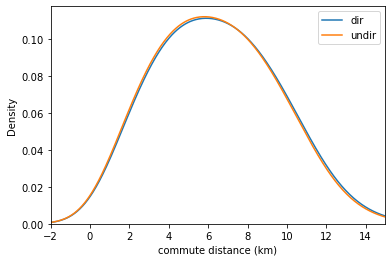

In [23]:
ax = (meters_dir/1000).plot.kde(label='dir', bw_method=bw)
ax = (meters_undir/1000).plot.kde(ax=ax, label='undir', bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-2, right=15)
ax.set_xlabel('commute distance (km)')
plt.legend()
plt.show()

In [24]:
# are the average distances (m) traveled per trip significantly different?
a = meters_dir
b = meters_undir
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1139349, δ=84.27, t=21.19, p=0.0000


In [25]:
a.mean() / b.mean()

1.01324159762761

In [26]:
difference = a - b
difference.describe()

count    1.139349e+06
mean     8.426751e+01
std      1.319803e+02
min     -1.818989e-12
25%      7.537000e+00
50%      3.841200e+01
75%      1.091270e+02
max      3.434825e+03
Name: network_distance_m, dtype: float64

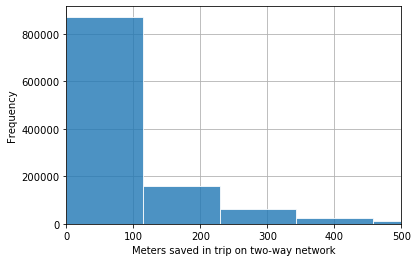

In [27]:
ax = difference.plot.hist(bins=30, ec='w', alpha=0.8, zorder=2)
ax.set_xlim(left=0, right=500)
ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_xlabel('Meters saved in trip on two-way network')
plt.show()

## Surplus VKT and fuel consumption

#### method 1

In [28]:
# daily km traveled in SF (trips entirely within SF only) https://www.sfcta.org/tncstoday
daily_km = 4586630

In [29]:
# estimate surplus VKT per day
surplus_vkt_daily = daily_km - (daily_km / (a.mean() / b.mean()))
surplus_vkt_daily

59940.599624933675

In [30]:
# estimate surplus VKT per year
surplus_vkt_daily * 365

21878318.86310079

#### method 2

In [31]:
total_daily_trips = 1133333 #how many trips begin and end in sf each day https://www.sfcta.org/tncstoday

In [32]:
# estimate surplus VKT per day
surplus_vkt_daily = total_daily_trips * (a.mean() - b.mean()) / 1000
surplus_vkt_daily

95503.15087538837

In [33]:
# estimate surplus VKT per year
surplus_vkt_daily * 365

34858650.069516756

#### fuel consumption

In [34]:
# how many surplus gallons of fuel does this waste per year?
fuel_econ = 39.75 # 23 mpg to km-p-g https://www.reuters.com/article/us-autos-emissions/u-s-vehicle-fuel-economy-rises-to-record-24-7-mpg-epa-idUSKBN1F02BX
surplus_fuel_gallons = (surplus_vkt_daily * 365) / fuel_econ
surplus_fuel_gallons

876947.1715601699

In [35]:
# burning a gallon of gas releases 20 lbs of CO2 https://www.fueleconomy.gov/feg/contentIncludes/co2_inc.htm
surplus_fuel_gallons * 20

17538943.4312034

## Save to disk

In [36]:
left = od_dir
right = od_undir[['network_distance_e', 'network_distance_m']]
df = pd.merge(left, right, left_index=True, right_index=True, suffixes=('_dir', '_undir'))
df.head()

,orig,dest,network_distance_e_dir,network_distance_m_dir,network_distance_e_undir,network_distance_m_undir
0,65287510,1711226144,35,3969.812,31,3930.790
1,65322699,4061762661,29,2941.941,27,2802.072
2,65372305,65347178,54,7720.505,50,7711.132
3,65347174,65316694,60,9109.966,56,9046.371
4,65316806,65308901,58,6532.745,51,6427.003


In [37]:
# save to disk
df.to_csv('data/od_distances-no-fwy-igraph-randomODs.csv', index=False, encoding='utf-8')